# <center> Example with Daubechies wavelets</center>

<br/>

<center>Héctor Andrade Loarca</center> 
<br/>

<center> Berliner Julians Meetup </center>

In [2]:
#push!(LOAD_PATH,pwd()*"/../../src") # for julia 0.4 you need to put your path
#import Shearlab
using Shearlab
using PyPlot

### Wavelets Filters

The 2-D wavelet transform of a continuous image $f(x)$ computes the set of inner products

$$ d_j^k[n] =\langle f,\psi_{j,n}^k\rangle$$

for scales $ j \in \mathbb{Z}$, position $ n \in \mathbb{Z}^2 $ and orientation $ k \in \{H,V,D\} $.


The wavelet atoms are defined by scaling and translating three mother
atoms $ \{\psi^H,\psi^V,\psi^D\} $:

$$ \psi_{j,n}^k(x) = \frac{1}{2^j}\psi^k\left(\frac{x-2^j n}{2^j}\right)$$

These oriented wavelets are defined by a tensor product of a 1-D wavelet
function $\psi(t)$ and a 1-D scaling function $\phi(t)$

$$ \psi^H(x)=\phi(x_1)\psi(x_2),  \text{ } \psi^V(x)=\psi(x_1)\phi(x_2)
\text{ and } \psi^D(x)=\psi(x_1)\psi(x_2).$$


The fast wavelet transform algorithm does not make use of the wavelet and scaling functions,
but of the filters $h$ and $g$ that caracterize their interaction:

$$ g[n] = \frac{1}{\sqrt{2}}\langle \psi(t/2),\phi(t-n)\rangle
\text{ and } h[n] = \frac{1}{\sqrt{2}}\langle\phi(t/2),\phi(t-n)\rangle. $$

### Filter design
We first generate the low pass filter Daubechies 2

In [4]:
?Shearlab.filt_gen

... filt_gen(WT.filter::Wavelets.WT) generates de desired filter with the next possible  choices:

  * Haar: WT.Haar
  * Coiflet: coif_n_ (n in 2:2:8)
  * Daubechies: db_n_ (n in 1:Inf)
  * Symlet: sym_n_ (n in 4:10)
  * Battle: batt_n_ (n in 2:2:6)
  * Beylkin: beyl

  * Vaidyanathan: vaid
  * CDF: cdf_n_ (n in (9,7))

#### Examples

#### filt_gen(WT.haar)

...


In [5]:
# Filter call
h=Shearlab.filt_gen(WT.db2)

5-element Array{Float64,1}:
  0.0     
  0.482963
  0.836516
  0.224144
 -0.12941 

Generate the high pass filter by $g[n] = (-1)^{1-n}h[1-n]$

In [6]:
# The filter associated to the wavelet function will be the mirror filter
g = Shearlab.mirror(h)

5-element Array{Float64,1}:
 -0.0     
 -0.12941 
 -0.224144
  0.836516
 -0.482963

### 1D-signal

Create a random 1D-signal, $f\in \mathbb{R}^N$ and compute  compute the
low pass signal $a \in \mathbb{R}^{N/2}$ and the high pass
signal $d \in \mathbb{R}^{N/2}$ as
$$ a = (f * h) \downarrow 2 \text{  and  }
d = (f * g) \downarrow 2$$
where the sub-sampling is defined as
$$ (u \downarrow 2)[k] = u[2k]. $$
where $g[n]=(-1)^{1-n}h[1-n]$.

In [7]:
N = 1024;
f = rand(N,1);

In [8]:
# Low/High pass filtering followed by sub-sampling
a = Shearlab.subsampling( Shearlab.cconvol(f,h) );
d = Shearlab.subsampling( Shearlab.cconvol(f,g) );

Since all the filters in FWT.jl are orthogonal one can recover the signal by the reverse procedure, filtering with the reversed filters and summing:
$$ (a \uparrow 2) * \tilde h + (d \uparrow 2) * \tilde g = f $$
where $\tilde h[n]=h[-n]$ (computed modulo $N$) and
$ (u \uparrow 2)[2n]=u[n] $ and  $ (u \uparrow 2)[2n+1]=0$.

In [9]:
f1 =  Shearlab.cconvol(Shearlab.upsampling(a),Shearlab.reverse(h)) +
        Shearlab.cconvol(Shearlab.upsampling(d),Shearlab.reverse(g));

In [10]:
#Reltive error
println("Error |f-f1|/|f| = ", norm(f[:]-f1[:])/norm(f[:]) );

Error |f-f1|/|f| = 1.6003996821692822e-16


### 2D-signal (forward wavelet transform)

First we load an image of $N= n \times n$ pixels, that for the first case is a picture of Ernst Reuter Haus in Straße der 17. Juni. 

In [13]:
n = 1024;
# The path of the image
name = "./../../data_samples/boat.bmp";
f = Shearlab.load_image(name, n);

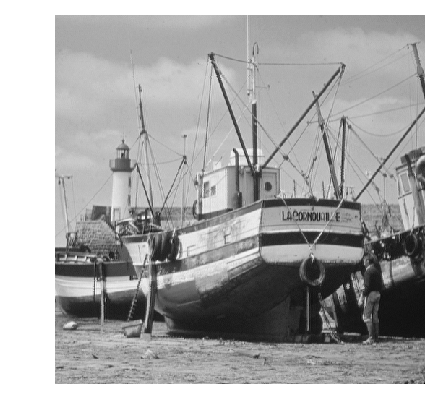

In [14]:
#Rescale image in [0,1] summing the 3 arrays in the RGB format
f = Shearlab.rescale(sum(f,3));
# Reduce one dimension 
f = f[:,:,1];
Shearlab.imageplot(f);

Lets first perform filtering/downsampling in the horizontal direction:

$$  \tilde a_{j-1} = (a_j *^H h) \downarrow^{2,H} \text{  and  } \tilde d_{j-1} = (a_j *^H g) \downarrow^{2,H}.$$

Here, the operator $*^H$ and $\downarrow^{2,H}$ are defined by applying $*$ and $\downarrow^2$ to each column of the matrix.


$$a_{j-1} = (\tilde a_j *^V h) \downarrow^{2,V} \text{  and  } d_{j-1}^V = (\tilde a_j *^V g) \downarrow^{2,V},$$ 

$$ d_{j-1}^H = (\tilde d_j *^V h) \downarrow^{2,V} \text{  and  } d_{j-1}^D =(\tilde d_j *^V g) \downarrow^{2,V}.$$

A wavelet transform is
computed by iterating high pass and low pass filterings with $h$ and $g$, followed by sub-samplings.


Since we are in 2-D, we need to compute these filterings+subsamplings
in the horizontal and then in the vertical direction (or
in the reverse order, it does not matter).


Initialize the transformed coefficients as the image itself and set the initial scale as the maximum one (coarsest scale).
fW will be iteratively transformated and will contains the
coefficients.

In [16]:
# Starts with coarsest scale
j = round(Int64,log2(n)-1);

In [17]:
# Sampling with the coarsest scale
fW = copy(f);
A = fW[1:2^(j+1),1:2^(j+1)];
# The high scales and low scales elements
Coarse = Shearlab.subsampling(Shearlab.cconvol(A,h,1),1);
Detail = Shearlab.subsampling(Shearlab.cconvol(A,g,1),1);

In [18]:
size(A),size(Coarse),size(Detail)

((1024,1024),(512,1024),(512,1024))

In [19]:
# Check energy conservation
norm(A[:])^2 - norm(Coarse[:])^2 - norm(Detail[:])^2

-1.8815171642927453e-10

In [20]:
#Concatenate them in the vertical direction
A = cat(1, Coarse, Detail );

In [21]:
size(A)

(1024,1024)

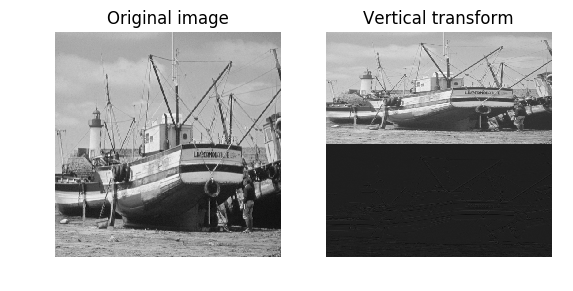

In [22]:
clf;
Shearlab.imageplot(f,"Original image",1,2,1);
Shearlab.imageplot(A,"Vertical transform",1,2,2);

Apply high and low filtering+subsampling in the horizontal direction (2nd coordinate), to get coarse and details.

In [23]:
Coarse = Shearlab.subsampling(Shearlab.cconvol(A,h,2),2);
Detail = Shearlab.subsampling(Shearlab.cconvol(A,g,2),2);

In [24]:
A = cat(2, Coarse, Detail );

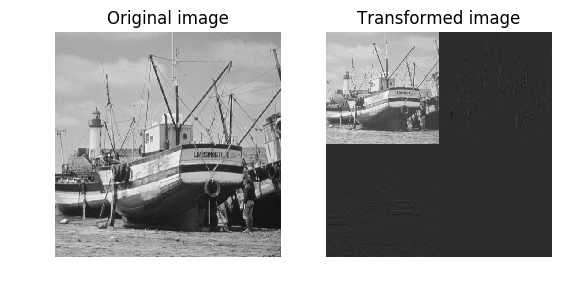

In [25]:
clf;
Shearlab.imageplot(f,"Original image",1,2,1);
Shearlab.imageplot(A,"Transformed image",1,2,2);

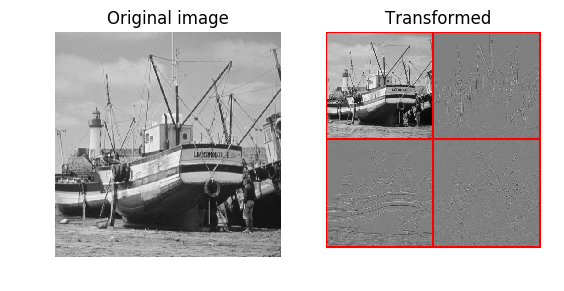

In [26]:
# Assign the transformed data and plot
fW[1:2^(j+1),1:2^(j+1)] = A;
clf;
Shearlab.imageplot(f,"Original image",1,2,1);
Shearlab.subplot(1,2,2);
Shearlab.plot_wavelet(fW,round(Int64,log2(n))-1); 
title("Transformed");

In [28]:
# Relative error
print( norm(f[:])-norm(fW[:]) )

-1.1368683772161603e-13

Now lets Implement a full wavelet transform that extract iteratively wavelet
coefficients, by repeating these steps. Take care of choosing the
correct number of steps.

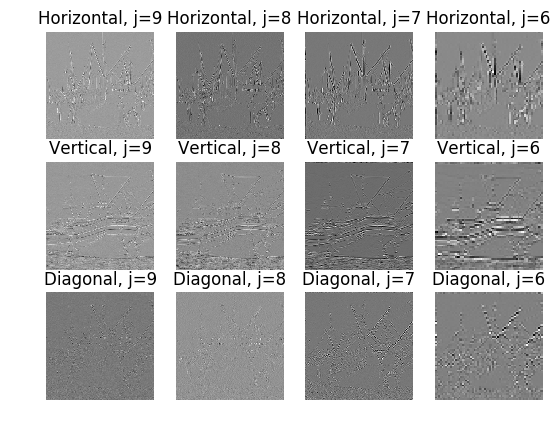

In [29]:
Jmax = round(Int64,log2(n))-1;
Jmin = 1;
fW = copy(f);
clf;
for j=Jmax:-1:Jmin
    A = fW[1:2^(j+1),1:2^(j+1)];
    for d=1:2
        Coarse = Shearlab.subsampling(Shearlab.cconvol(A,h,d),d);
        Detail = Shearlab.subsampling(Shearlab.cconvol(A,g,d),d);
        A = cat(d, Coarse, Detail );
    end
    fW[1:2^(j+1),1:2^(j+1)] = A;
    j1 = Jmax-j;
    if j1<4
        Shearlab.imageplot(A[1:2^j,2^j+1:2^(j+1)], "Horizontal, j=$j", 3,4, j1 + 1);
        Shearlab.imageplot(A[2^j+1:2^(j+1),1:2^j], "Vertical, j=$j", 3,4, j1 + 5);
        Shearlab.imageplot(A[2^j+1:2^(j+1),2^j+1:2^(j+1)], "Diagonal, j=$j", 3,4, j1 + 9);
    end
end

Check for orthogonality of the transform (conservation of energy).

In [30]:
e0 = norm(f[:])^2; 
e1 = norm(fW[:])^2; 
println("Energy of the signal       = $e0");
println("Energy of the coefficients = $e1");

Energy of the signal       = 390421.47903573094
Energy of the coefficients = 390421.4790357308


Display the wavelet coefficients in each scale.

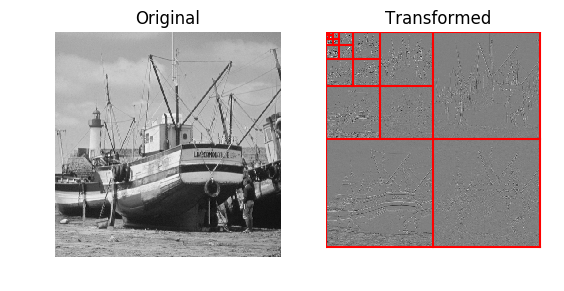

In [31]:
clf;
Shearlab.imageplot(f, "Original", 1,2,1);
Shearlab.subplot(1,2,2);
Shearlab.plot_wavelet(fW, Jmin); 
title("Transformed");

## Inverse 2-D Wavelet transform.

Inversing the wavelet transform means retrieving a signal $f_1$ from the coefficients $fW$. If $fW$ are exactely the coefficients of $f$, then
$f=f_1$ up to machine precision.

Initialize the image to recover $f_1$ as the transformed coefficient, and
select the smallest possible scale.

In [32]:
f1 = copy(fW);
Jmax = round(Int64,log2(n))-1;
j=Jmax

9

In [33]:
# Select the sub-coefficient to transform
A = f1[1:2^(j+1),1:2^(j+1)];

In [34]:
size(A)

(1024,1024)

Retrieve coarse and detail coefficients in the vertical direction (you
can begin by the other direction, this has no importance).

In [35]:
Coarse = A[1:2^j,:];
Detail = A[2^j+1:2^(j+1),:];

Undo the transform by up-sampling and then dual filtering.

In [36]:
Coarse = Shearlab.cconvol(Shearlab.upsampling(Coarse,1),Shearlab.reverse(h),1);
Detail = Shearlab.cconvol(Shearlab.upsampling(Detail,1),Shearlab.reverse(g),1);

In [37]:
size(Coarse)

(1024,1024)

In [38]:
#Recover the coefficient by summing.
A = Coarse + Detail;

In [39]:
# Assign the result
f1[1:2^(j+1),1:2^(j+1)]= A;

Now lets write the inverse wavelet transform that computes $f_1$ from the coefficients $fW$.
 
 Compare $f_1$ with $f$.

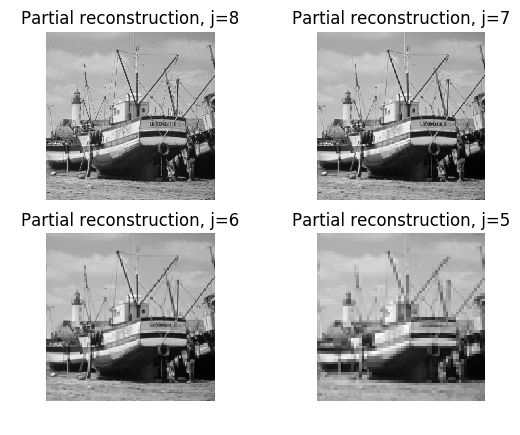

In [40]:
f1 = copy(fW);
clf;
for j=Jmin:Jmax
    A = f1[1:2^(j+1),1:2^(j+1)];
    for d=1:2
        if d==1
            Coarse = A[1:2^j,:];
            Detail = A[2^j+1:2^(j+1),:];
        else
            Coarse = A[:,1:2^j];
            Detail = A[:,2^j+1:2^(j+1)];                
        end
        Coarse = Shearlab.cconvol(Shearlab.upsampling(Coarse,d),Shearlab.reverse(h),d);
        Detail = Shearlab.cconvol(Shearlab.upsampling(Detail,d),Shearlab.reverse(g),d);
        A = Coarse + Detail;
        j1 = Jmax-j;
        if j1>0 && j1<5
            Shearlab.imageplot(A, "Partial reconstruction, j=$j", 2,2,j1);
        end
    end
    f1[1:2^(j+1),1:2^(j+1)] = A;
end

In [41]:
# Checking the relative error
e = norm(f[:]-f1[:])/norm(f[:]);
print("Error |f-f1|/|f| = $e");

Error |f-f1|/|f| = 1.161238501575346e-15

Linear 2-D Wavelet Approximation
--------------------------------

Linear approximation is performed by setting to zero the fine scale wavelets coefficients
and then performing the inverse wavelet transform.

Here we keep only $1/16$ of the wavelet coefficient, thus calculating an $m$
term approximation with $m=n^2/16$.

In [42]:
η = 4;
fWLin = zeros(n,n);
fWLin[map(Int,1:n/η),map(Int,1:n/η)] = fW[map(Int,1:n/η),map(Int,1:n/η)];

Now, lets compute and display the linear approximation $fLin$ obtained from the
coefficients $fWLin$ by inverse wavelet transform.

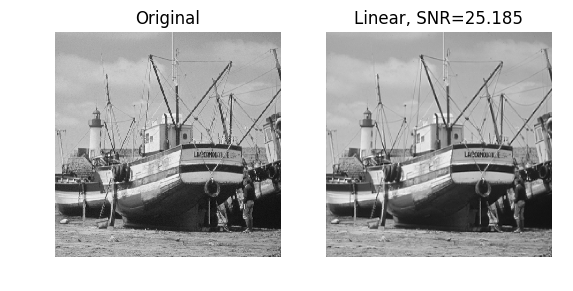

In [43]:
Jmin = 1;
# forward transform
fW = Shearlab.perform_wavortho_transf(f,Jmin,+1,h);
# linear approximation
η = 4;
fWLin = zeros(n,n);
fWLin[map(Int,1:n/η),map(Int,1:n/η)] = fW[map(Int,1:n/η),map(Int,1:n/η)];
# backward transform
fLin = Shearlab.perform_wavortho_transf(fWLin,Jmin,-1,h);
elin = Shearlab.snr(f,fLin);
# display
clf;
Shearlab.imageplot(f, "Original", 1,2,1); 
u = @sprintf("Linear, SNR=%.3f", elin);
Shearlab.imageplot(Shearlab.clamp(fLin), u, 1,2,2);

Non-Linear 2-D Wavelet Approximation
------------------------------------

A non-linear $m$-term approximation is obtained by keeping only the $m$ largest coefficients, which creates the smallest possible error.

Removing the smallest coefficient, to keep the $m$-largest, is
equivalently obtained by thresholding the coefficients to
set to 0 the smallest coefficients.

First select a threshold value (the largest the threshold, the more agressive the approximation)

In [44]:
T = .2;
# Set to 0 coeff with magnitude bellow T
fWT = fW .* float(abs.(fW).>T);

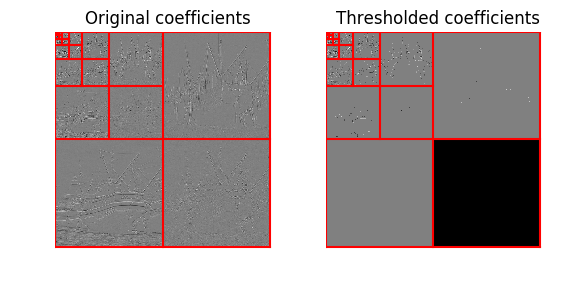

In [45]:
# Display threshold coefficients
clf;
Shearlab.subplot(1,2,1);
Shearlab.plot_wavelet(fW,Jmin); 
title("Original coefficients");
subplot(1,2,2);
Shearlab.plot_wavelet(fWT,Jmin); 
title("Thresholded coefficients");

Now lets find the thresholds $T$ so that the number $m$ of remaining coefficients in $fWT$ are $m=n^2/16$. Lets use this threshold to compute $fWT$ and then display the corresponding approximation $(M_n)_{lin}$ of $f$. Lets compare finally this result with the linear approximation.

In [46]:
# number of kept coefficients
m = round(n^2/16); 
# compute the threshold T
Jmin = 1;
fW = Shearlab.perform_wavortho_transf(f,Jmin,+1, h); 
# select threshold
v = sort(abs.(fW[:])); 
if v[1]<v[n^2]
    v = Shearlab.reverse(v);
end
# inverse transform
T = v[Int(m)];
fWT = fW .* (abs.(fW).>T);2
# inverse
fnlin = Shearlab.perform_wavortho_transf(fWT,Jmin,-1, h);

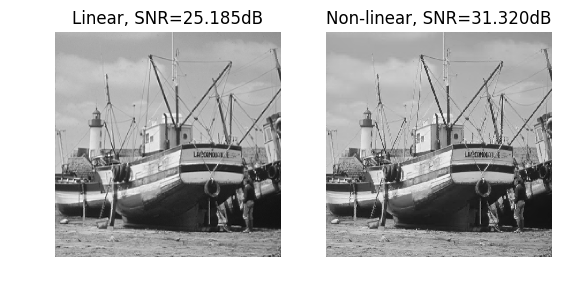

In [47]:
# display
clf;
u1 = @sprintf("Linear, SNR=%.3fdB", Shearlab.snr(f,fLin));
u2 = @sprintf("Non-linear, SNR=%.3fdB", Shearlab.snr(f,fnlin)); 
Shearlab.imageplot(Shearlab.clamp(fLin),u1, 1,2,1 );
Shearlab.imageplot(Shearlab.clamp(fnlin),u2, 1,2,2 );